In [25]:
import sys
plist = ['/Applications/NEURON/lib/python']
for pd in plist:
    if pd in sys.path:
        sys.path.remove(pd)

In [26]:
from __future__ import division
from neuron import h, gui, rxd 
from neuron.units import ms, mV, µm
import matplotlib.pyplot as plt
import numpy as np
import math

h.load_file("stdrun.hoc")
h.celsius = 35 # set the reaction temperature

tt = 100 * ms # runtime

def levelcheck(x):  
    return 1 if x == 0 else int(math.log(x)/math.log(2)+1)

In [27]:
# Model 
soma = h.Section(name="soma")
soma.L = soma.diam = 12.6157 # µm
soma.insert('pas')

nsegnum = 1000

# define cytosol
cyt = rxd.Region(soma.wholetree(), name="cyt", nrn_region="i")
# define sodium
na = rxd.Species(cyt, name="na", charge=1)

# by default, both end of dendrite are sealed end
num_of_dend = 15
dendlst = [h.Section(name='dend[%d]' % i) for i in range(num_of_dend)]
lambdalst = []
rinftylst = []

Rm = 23000 # Membrane resistence Ohm cm^2
# parameter for the primary branch of the dendrite
prim_L = 500
prim_D = 2

for sec in h.allsec():
    sec.Ra = 100 # Axial resistance Ohm * cm
    sec.cm = 1 # Membrane capacitance micro Farads / cm^2

for i in range(len(dendlst)):
    dend = dendlst[i]
    dend.L = prim_L / 2**(levelcheck(i+1)-1) # µm
    # 3/2 rule
    dend.diam = prim_D * 0.63**(levelcheck(i+1)-1) # µm
    dend.nseg = nsegnum

    # characteristic length of membrane cylinder
    cl_lambda = ((Rm/dend.Ra)*(dend.diam/4))**(1/2)
    lambdalst.append(cl_lambda)

    # input resistance at origin of membrane cylinder of semi-infinite length
    rinfty = (2/math.pi)*(Rm/dend.Ra)**(1/2)*(dend.diam)**(-3/2)
    rinftylst.append(rinfty)

    # insert passive current in the dendrite 
    dend.insert('pas')
    for seg in dend:    
        seg.pas.g = 1/Rm # Passive conductance, S/cm2
        seg.pas.e = -64.85 # Leak reversal potential, mV

    # connection
    # by default, all dendrites have sealed end, meaning that dV/dt 
    # (flux passing through the end) = 0 
    if i + 1 == 1:
        dend.connect(soma,1.0) 
    else:
        if (i + 1) % 2 == 0:
            dend.connect(dendlst[int((i+1)/2-1)])
        else:
            dend.connect(dendlst[int(i/2-1)])
            
dll = [i.L for i in dendlst] # dendrite length set
# dll = [dll[i]/lambdalst[i] for i in range(len(dendlst))] # electronic distance for each branch of dendrite

# construct total dend branch in the tree
def con_dendll(dendnum,L):
    ll = levelcheck(dendnum)
    dendll = [0]
    kk = 1
    while kk <= ll:
        dendll.append(L/2**(kk-1)+dendll[kk-1])
        kk += 1
    return dendll[1:]

dendll = con_dendll(num_of_dend,prim_L)

In [28]:
###
# set up experiment 
###
inject_ind = 0

distaldend = dendlst[-1] # the leaf branch of dendrite
maindend = dendlst[0] # main dendrite connect to the soma
secdend = dendlst[1]
thidend = dendlst[3]
fourthdend = dendlst[7]

# use approximal end of dendrite
approxend = 0.999
approxstart = 0.001

# add 1 spine
# connect to the model
def add_spine(cp,cloc):
    shead = h.Section(name='spine head')
    shead.diam = 0.75
    shead.L = 0.5
    shead.Ra = 100 # Ohm * cm
    shead.nseg = nsegnum
    shead.insert('pas')

    sneck = h.Section(name='spine neck')
    sneck.diam = 0.2
    sneck.L = 0.5
    sneck.Ra = 100 # Ohm * cm
    sneck.nseg = nsegnum
    sneck.insert('pas')

    shead.connect(sneck,1)
    sneck.connect(cp,cloc)
    return [shead,sneck]


# define injection current
if inject_ind == 0:
    stim = h.IClamp(distaldend(approxend))
    stim.delay = 0
    stim.dur = 1e9 # ms 
    stim.amp = 0.1 # nA

    # injected current
    stim_current = h.Vector().record(stim._ref_i) # record the injection current
    # record spine dynamics
    # spine_record = []
    # spine_storage = []
    # name_loc = []

    # conndend = [maindend,secdend,thidend,fourthdend]
    # loclst = [0.25,0.5,0.75,1.00]
    # for ii in range(len(conndend)):
    #     for jj in range(len(loclst)):
    #         segm = add_spine(conndend[ii],loclst[jj])
    #         spine_storage.append(segm)
    #         spine_record.append(h.Vector().record(spine_storage[-1][0](0.5)._ref_v))
    #         name_loc.append([ii,jj])

elif inject_ind == 1:
    cp = maindend
    cloc = 0.01

    [shead,sneck] = add_spine(cp,cloc)
    
    # define an excitatory synapse to receive event (these will trigger the cell to spike)
    addsyp = soma
    sloc = 0.5

    syn_ = h.ExpSyn(addsyp(sloc))
    syn_.tau = 1 * ms
    syn_.e = 0 * mV
    # define spike event
    stim = h.NetStim()
    stim.interval = 1e9 * ms
    stim.number = 1
    stim.start = 0 * ms
    # send those event to synpse
    nc = h.NetCon(stim,syn_)
    nc.weight[0] = 0.01

    # synapse current
    stim_current = h.Vector().record(syn_._ref_i)

    head_v = h.Vector().record(shead(0.5)._ref_v)
    neck_v = h.Vector().record(sneck(0.5)._ref_v)
    cp_v = h.Vector().record(cp(cloc)._ref_v)

soma_v = h.Vector().record(soma(0.5)._ref_v)

if inject_ind == 1:
    na_vec = h.Vector().record(soma(0.5)._ref_nai)
    ina = h.Vector().record(soma(0.5)._ref_ina)

# record the voltage at end of each dendrite
dend_vs = []
for dend in dendlst:
    dend_vs.append(h.Vector().record(dend(1.0)._ref_v))

# record the voltage dynamic at different locations of the primary dendrite
maindend_vs = []
locspace = np.linspace(0.0,1.0,num=5)
for theloc in locspace:
    maindend_vs.append(h.Vector().record(maindend(theloc)._ref_v))

t = h.Vector().record(h._ref_t)

h.v_init = -66 * mV # setting the rest potential

# display the structure
# h.topology()
# s = h.Shape()

In [29]:
###
# Add active channels to the soma and run simulation
###

# here we use Hodgkin Huxley Model
soma.insert('hh')

h.tstop = tt

if inject_ind == 0:
    stim.dur = 1e9
    stim_current = h.Vector().record(stim._ref_i)

# default parameter of HH
for seg in soma:
    seg.hh.gnabar = 0.12 # Sodium conductance, S/cm2
    seg.hh.gkbar = 0.036 # Potassium conductance, S/cm2
    seg.hh.gl = 0.0003 # Leak conductance, S/cm2
    seg.hh.el = -54.3 # Reversal potential, mV
    
h.run()    

0.0

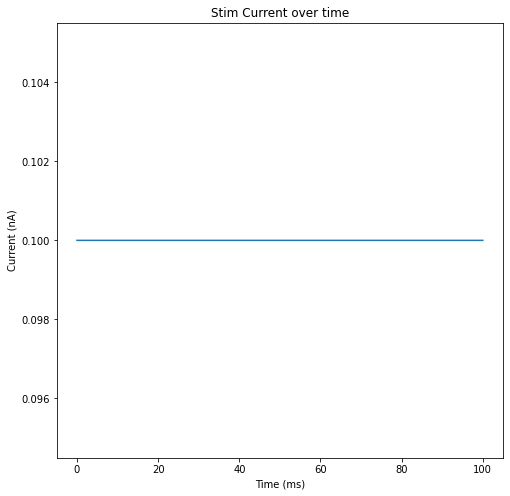

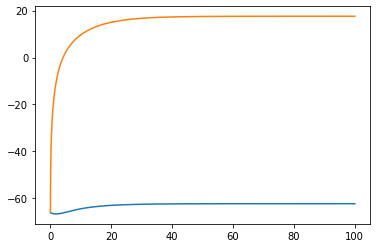

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


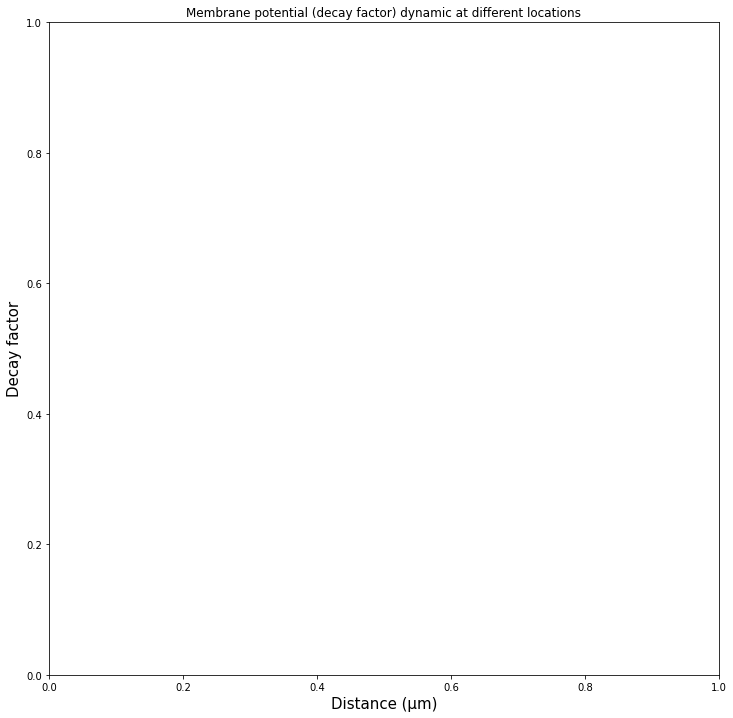

0.04437839239693871


In [30]:
plt.figure(figsize=(8,8))
plt.plot(t,stim_current)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.title('Stim Current over time')

if inject_ind == 1: 
    plt.figure(figsize=(8,8))
    plt.plot(t,head_v,label=f'spine head,max time: {round(t[np.argmax(head_v)],2)}ms')
    plt.plot(t,neck_v,label=f'spine neck,max time: {round(t[np.argmax(neck_v)],2)}ms')
    plt.plot(t,cp_v,label=f'connection at {cloc} of {cp.name()}, max time: {round(t[np.argmax(cp_v)],2)}ms')

    plt.legend(fontsize = 14, frameon=False)
    plt.xlabel('Time (ms)', fontsize = 15)
    plt.ylabel('Voltage (mV)', fontsize = 15)   

plt.figure()
plt.plot(t,soma_v,label='soma')
plt.plot(t,dend_vs[-1],label='leaf dendrite')
plt.show()

# print((max(head_v-h.v_init))/(max(soma_v)-h.v_init))

plt.figure(figsize=(12,12))
vvlst = [] # store the maximum value of the membrane potential list
# plt.plot(t,soma_v,color='r',label='soma(0.5)')
vvlst.append(max(soma_v)-h.v_init) # add soma (vvlst[0])
# for i,v in list(enumerate(spine_record)):
#     place = name_loc[i]
#     [thedend,theloc] = [place[0],place[1]]
#     if thedend == 0:
#         dts = loclst[theloc] * prim_L
#     else:
#         dts = dendll[thedend-1] + loclst[theloc] * (dendll[thedend]-dendll[thedend-1])
#     tlabel = f"level {thedend+1},dist to soma={dts}"

#     plt.plot(t,v,label=tlabel)
    # plt.scatter(dts,(max(v)-h.v_init)/(max(dend_vs[-8])-h.v_init))
    
vvlst = np.array(vvlst)

plt.xlabel('Distance (µm)', fontsize = 15)
plt.ylabel('Decay factor', fontsize = 15)
plt.legend(fontsize = 14, frameon=False,loc=7)
plt.title('Membrane potential (decay factor) dynamic at different locations')
# plt.axis([None,None,0,1])
plt.show()

a1 = soma_v[-1]-h.v_init
a2 = dend_vs[-1][-1]-h.v_init
rr = a1/a2
if rr < 1:
    print(rr)
else:
    print(1/rr)

500.0
22.533488618866276


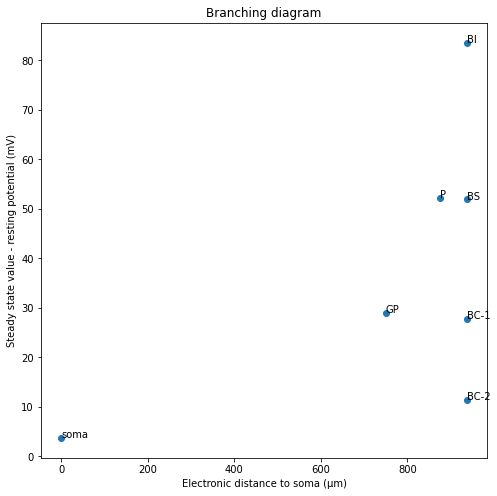

In [31]:
# similar to Rall & Rinzel 1973 Fig 4
# 4-level dendritic structure

if num_of_dend == 15 and inject_ind == 0:
    loc = [0,
        dll[0]+dll[2],
        dll[0]+dll[2]+dll[6],
        dll[0]+dll[2]+dll[6]+dll[14],
        dll[0]+dll[2]+dll[6]+dll[13],
        dll[0]+dll[2]+dll[6]+dll[12],
        dll[0]+dll[1]+dll[4]+dll[9]
    ]
    print(dll[0])
    voltage = [soma_v[-1]-h.v_init,
        dend_vs[2][-1]-h.v_init,
        dend_vs[6][-1]-h.v_init,
        dend_vs[14][-1]-h.v_init,
        dend_vs[13][-1]-h.v_init,
        dend_vs[12][-1]-h.v_init,
        dend_vs[9][-1]-h.v_init
    ]
    label = ['soma','GP','P','BI','BS','BC-1','BC-2']
    
    plt.figure(figsize=(8,8))
    plt.scatter(loc,voltage)
    for i,txt in enumerate(label):
        plt.annotate(txt,(loc[i],voltage[i]))
    plt.xlabel('Electronic distance to soma (µm)')
    plt.ylabel('Steady state value - resting potential (mV)')
    plt.title('Branching diagram')

print(max(voltage)/min(voltage))